<a href="https://colab.research.google.com/github/deqiangwang123/3253-Machine-Learning/blob/main/W3_Homework_DW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q1 Classification
Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50} 
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 4-folds.

- Other paramenters -> Use default

Notes:
  - Make your code modular, the second part of the assignmet you will have to repeat. 
  - Include documentation for your code 

##Global Function

In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1, Get the data

### Load data

In [2]:
# Upgrade xlrd version to use read_excel
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 1.7 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [3]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2, Data Exploration

### Check missing data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

The dataset has 23 attributes, where "default payment next month" will be the target. There are 30000 instances and no missing attributes. If any missing data, one option is to use median value to fill the blanks.

### Study the attributes

In [5]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]

# add f in the front to print variable with {}
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


"default payment next month" will be the target attribute. From the description of the dataset, the categorical attributes are selected out then the left are the numerical attributes.

### Choose X and y

In [12]:
X = df[columns_predictors]
y = df[TARGET]

In [13]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [15]:
y.value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

### Check the balance of the dataset

In [6]:
def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique)
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%')

0    23364
1     6636
Name: default payment next month, dtype: int64

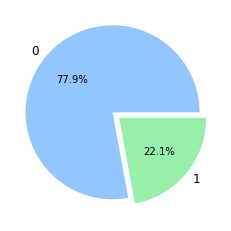

In [7]:
check_data_balance(df["default payment next month"])

From the pie chart, the study case has imbalanced data.

### Split dataset to train and test

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
# stratified based on y, so train_test_split can do stratified sampling 
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (24000, 23)
X_test.shape: (6000, 23)
y_train.shape: (24000,)
y_test.shape: (6000,)


0    18691
1     5309
Name: default payment next month, dtype: int64

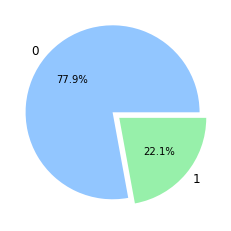

In [34]:
check_data_balance(y_train)

0    4673
1    1327
Name: default payment next month, dtype: int64

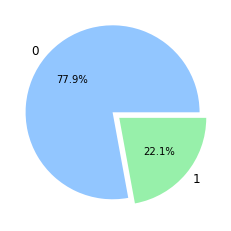

In [35]:
check_data_balance(y_test)

### Visualized the data by Histogram

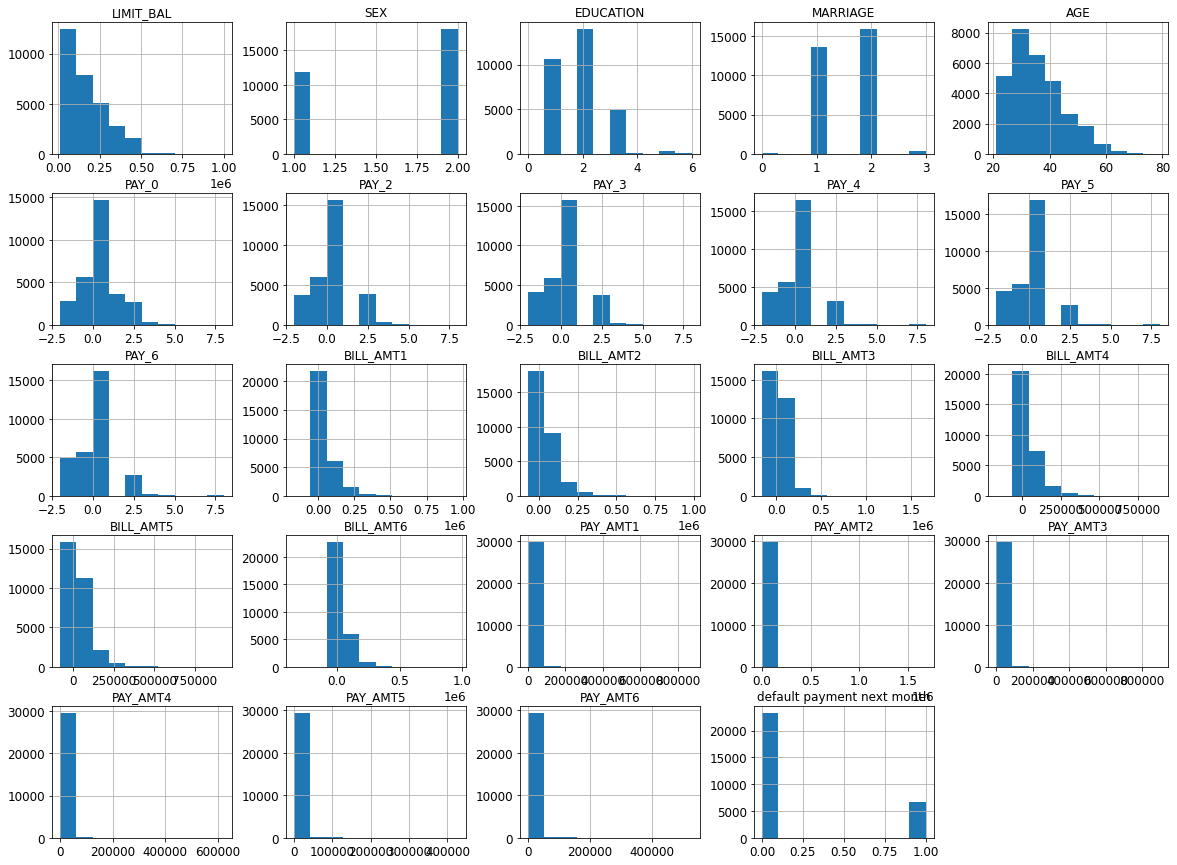

In [8]:
_=df.hist(figsize=(20,15))

### Correlations between attributes

In [9]:
corr_matrix = df.corr()
corr_matrix[TARGET].sort_values(ascending=False)

default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDUCATION                     0.028006
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
MARRIAGE                     -0.024339
SEX                          -0.039961
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
Name: default payment next month, dtype: float64

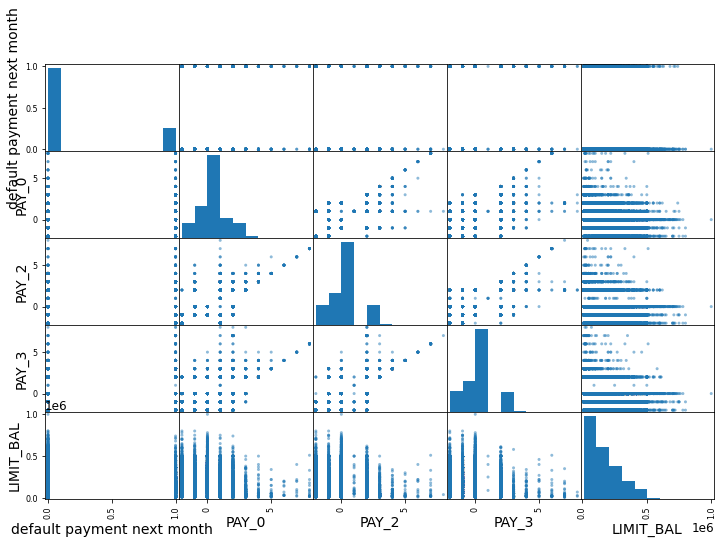

In [10]:
from pandas.plotting import scatter_matrix
attributes = [TARGET, "PAY_0", "PAY_2", "PAY_3", "LIMIT_BAL"]
_=scatter_matrix(df[attributes], figsize=(12,8))

**From the scatter_matrix figure, it is hard to tell if there is a strong linear relationship between the target and the attributes. So I'm not sure if correlation is a good metric to study the feature for classification problem.**

## 3, Preprocessing Data

### Create pipeline

Create pipeline to preprocessing data. Use onehot for categorical attributes, do feature scaling for numerical attributes. To diff with demo, standardization is used instead of MinMax. 

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder()),
])

pipeline_numerical = Pipeline([
  ('scaler', StandardScaler()),
])

pipeline_pre = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

In [21]:
pipeline_numerical.fit_transform(X_train[columns_numerical]).shape

(24000, 14)

In [31]:
pipeline_categorical.fit_transform(X_train[columns_categorical]).toarray().shape

(24000, 77)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 23834 to 13417
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  24000 non-null  int64
 1   SEX        24000 non-null  int64
 2   EDUCATION  24000 non-null  int64
 3   MARRIAGE   24000 non-null  int64
 4   AGE        24000 non-null  int64
 5   PAY_0      24000 non-null  int64
 6   PAY_2      24000 non-null  int64
 7   PAY_3      24000 non-null  int64
 8   PAY_4      24000 non-null  int64
 9   PAY_5      24000 non-null  int64
 10  PAY_6      24000 non-null  int64
 11  BILL_AMT1  24000 non-null  int64
 12  BILL_AMT2  24000 non-null  int64
 13  BILL_AMT3  24000 non-null  int64
 14  BILL_AMT4  24000 non-null  int64
 15  BILL_AMT5  24000 non-null  int64
 16  BILL_AMT6  24000 non-null  int64
 17  PAY_AMT1   24000 non-null  int64
 18  PAY_AMT2   24000 non-null  int64
 19  PAY_AMT3   24000 non-null  int64
 20  PAY_AMT4   24000 non-null  int64
 21  PAY_AMT5

### Apply pipeline

Appy fit to train dataset then transformer to train and test to avoid information leak of test data.

In [37]:
pipeline_pre.fit(X_train)
X_train_transformed = pipeline_pre.transform(X_train)
X_test_transformed = pipeline_pre.transform(X_test)

In [39]:
X_train_transformed.shape

(24000, 91)

## 4, Select and Train Promising Models

### Logistic Regression 

In [40]:
from sklearn.linear_model import LogisticRegression

logis_reg = LogisticRegression(n_jobs=-1, random_state=123)
logis_reg.fit(X_train_transformed, y_train)

LogisticRegression(n_jobs=-1, random_state=123)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_train_pred_lr = logis_reg.predict(X_train_transformed)
y_train_pred_proba_lr = logis_reg.predict_proba(X_train_transformed)

print(f"accuracy_score: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"precision_score: {precision_score(y_train, y_train_pred_lr)}")
print(f"recall_score: {recall_score(y_train, y_train_pred_lr)}")
print(f"f1_score: {f1_score(y_train, y_train_pred_lr)}")
print(f"roc_auc_score: {roc_auc_score(y_train, y_train_pred_proba_lr[:,1])}")

accuracy_score: 0.8214583333333333
precision_score: 0.6840402588066139
recall_score: 0.35844791862874364
f1_score: 0.47039920899765164
roc_auc_score: 0.7719093608691092


In [60]:
from sklearn.model_selection import cross_val_score

cv_score_mean_lg = cross_val_score(logis_reg, X_train_transformed, y_train, cv=4, scoring="roc_auc").mean()
print(f"roc_auc_score_cross_validation_mean: {cv_score_mean_lg}")

roc_auc_score_cross_validation_mean: 0.7674763920711329


### SGD

In [52]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=123)
sgd_clf.fit(X_train_transformed, y_train)

SGDClassifier(max_iter=5, random_state=123, tol=-inf)

In [55]:
y_train_pred_sgd = sgd_clf.predict(X_train_transformed)
# y_trai_pred_proba_sgd = sgd_clf.predict_proba(X_train_transformed)

print(f"accuracy_score: {accuracy_score(y_train, y_train_pred_sgd)}")
print(f"precision_score: {precision_score(y_train, y_train_pred_sgd)}")
print(f"recall_score: {recall_score(y_train, y_train_pred_sgd)}")
print(f"f1_score: {f1_score(y_train, y_train_pred_sgd)}")
print(f"roc_auc_score: {roc_auc_score(y_train, y_train_pred_sgd)}")

accuracy_score: 0.758875
precision_score: 0.45359223300970875
recall_score: 0.44000753437558865
f1_score: 0.44669662491634005
roc_auc_score: 0.6447268959663509


In [61]:
cv_score_mean_sgd = cross_val_score(sgd_clf, X_train_transformed, y_train, cv=4, scoring="roc_auc").mean()
print(f"roc_auc_score_cross_validation_mean: {cv_score_mean_sgd}")

roc_auc_score_cross_validation_mean: 0.692399954107537


### Random Forest



In [70]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10, random_state=123)
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=10, random_state=123)

In [71]:
y_train_pred_rf = rf_clf.predict(X_train_transformed)
y_train_pred_proba_rf= rf_clf.predict_proba(X_train_transformed)

print(f"accuracy_score: {accuracy_score(y_train, y_train_pred_rf)}")
print(f"precision_score: {precision_score(y_train, y_train_pred_rf)}")
print(f"recall_score: {recall_score(y_train, y_train_pred_rf)}")
print(f"f1_score: {f1_score(y_train, y_train_pred_rf)}")
print(f"roc_auc_score: {roc_auc_score(y_train, y_train_pred_proba_rf[:,1])}")

accuracy_score: 0.9806666666666667
precision_score: 0.9938837920489296
recall_score: 0.9182520248634395
f1_score: 0.9545721558644998
roc_auc_score: 0.9992079251344035


In [80]:
cv_score_mean_rf = cross_val_score(rf_clf, X_train_transformed, y_train, cv=4, scoring="roc_auc").mean()
print(f"roc_auc_score_cross_validation_mean: {cv_score_mean_rf}")

roc_auc_score_cross_validation_mean: 0.7281493298940624


In [69]:
cross_val_score(rf_clf, X_train_transformed, y_train, cv=4, scoring="roc_auc")

array([0.72965243, 0.73407916, 0.71023288, 0.73863285])

It looks like, the RandomForest is overfitting.

### KNN Classifier

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=10)

In [77]:
y_train_pred_knn = knn_clf.predict(X_train_transformed)
y_train_pred_proba_knn= knn_clf.predict_proba(X_train_transformed)

print(f"accuracy_score: {accuracy_score(y_train, y_train_pred_knn)}")
print(f"precision_score: {precision_score(y_train, y_train_pred_knn)}")
print(f"recall_score: {recall_score(y_train, y_train_pred_knn)}")
print(f"f1_score: {f1_score(y_train, y_train_pred_knn)}")
print(f"roc_auc_score: {roc_auc_score(y_train, y_train_pred_proba_knn[:,1])}")

accuracy_score: 0.8258333333333333
precision_score: 0.7496682883679787
recall_score: 0.3192691655679036
f1_score: 0.44782034346103045
roc_auc_score: 0.8380902149670305


In [83]:
%%time
cv_score_mean_knn = cross_val_score(knn_clf, X_train_transformed, y_train, cv=4, scoring="roc_auc").mean()
print(f"roc_auc_score_cross_validation_mean: {cv_score_mean_knn}")

roc_auc_score_cross_validation_mean: 0.7184352630041347
CPU times: user 42.4 s, sys: 1.71 s, total: 44.2 s
Wall time: 45.1 s


In [81]:
cross_val_score(knn_clf, X_train_transformed, y_train, cv=4, scoring="roc_auc")

array([0.72990254, 0.71242387, 0.70414982, 0.72726482])

### Comparison by roc_auc score

In [84]:
dat_dtype = {
    'names' : ('LogisticRegression', 'SGD', 'RandomForest','KNN'),
    'formats' : ('d', 'd', 'd','d')}
dat = np.zeros(1, dat_dtype)
dat['LogisticRegression'] = cv_score_mean_lg
dat['SGD'] = cv_score_mean_sgd
dat['RandomForest'] = cv_score_mean_rf
dat['KNN'] = cv_score_mean_knn

print(dat)

[(0.76747639, 0.69239995, 0.72814933, 0.71843526)]


In [101]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["ML","Mean of roc_auc from CV 4 fold"]
table.add_row(["LogisticRegression", cv_score_mean_lg])
table.add_row(['SGD', cv_score_mean_sgd])
table.add_row(['RandomForest', cv_score_mean_rf])
table.add_row(['KNN', cv_score_mean_knn])
print(table)

+--------------------+--------------------------------+
|         ML         | Mean of roc_auc from CV 4 fold |
+--------------------+--------------------------------+
| LogisticRegression |       0.7674763920711329       |
|        SGD         |       0.692399954107537        |
|    RandomForest    |       0.7281493298940624       |
|        KNN         |       0.7184352630041347       |
+--------------------+--------------------------------+


## 5, Fine-Tune

### Grid Search

#### RandomForest

In [125]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = [
      {'n_estimators':[3, 4, 6, 7, 10, 20, 50, 100]},
]
rf_clf = RandomForestClassifier(random_state=123)
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=4,
                           scoring='roc_auc', return_train_score=True)


In [126]:
%%time
grid_search_rf.fit(X_train_transformed, y_train)

CPU times: user 3min 14s, sys: 27.6 s, total: 3min 42s
Wall time: 3min 41s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=123),
             param_grid=[{'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100]}],
             return_train_score=True, scoring='roc_auc')

In [108]:
grid_search_rf.best_params_

{'n_estimators': 100}

In [127]:
grid_search_rf.best_estimator_

RandomForestClassifier(random_state=123)

In [128]:
grid_search_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [111]:
cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6731691018998589 {'n_estimators': 3}
0.6926237504916737 {'n_estimators': 4}
0.7095450354353239 {'n_estimators': 6}
0.7156158434403523 {'n_estimators': 7}
0.7281493298940624 {'n_estimators': 10}
0.7482372006151663 {'n_estimators': 20}
0.7614701034898237 {'n_estimators': 50}
0.766593759783923 {'n_estimators': 100}


In [129]:
feature_importance = grid_search_rf.best_estimator_.feature_importances_

In [130]:
feature_importance

array([9.15925197e-03, 8.92898619e-03, 1.73669039e-05, 8.51154832e-03,
       9.75657886e-03, 7.69002566e-03, 4.53135471e-04, 8.16034149e-04,
       4.76622751e-04, 3.02205425e-04, 9.42700879e-03, 9.28709419e-03,
       1.95330074e-03, 2.34686142e-03, 5.96410834e-03, 1.49701353e-02,
       7.36449204e-03, 5.13103649e-02, 3.96793955e-03, 6.07410631e-04,
       1.24347315e-04, 7.37251218e-05, 3.71709268e-05, 1.07667439e-04,
       1.74125295e-03, 4.01929439e-03, 5.68862393e-03, 1.85067080e-04,
       2.80105154e-02, 2.57207460e-03, 3.83927184e-04, 1.55856717e-04,
       5.84589576e-05, 6.53192854e-05, 1.08601526e-05, 1.65729519e-03,
       4.04995680e-03, 4.83120658e-03, 5.26001728e-06, 1.89069320e-02,
       1.05624864e-03, 4.13302851e-04, 1.05109817e-04, 9.41212129e-05,
       1.23285423e-04, 1.14307600e-05, 2.81184648e-03, 3.47200744e-03,
       4.97140287e-03, 2.50935382e-08, 1.77255358e-02, 8.97326951e-04,
       4.95887636e-04, 2.00381308e-04, 1.98681741e-05, 3.68708386e-04,
      

#### KNN Classifier

In [112]:
param_grid_knn = [
      {'n_neighbors':[3, 4, 5, 7, 10, 20, 50]},
]
knn_clf = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_clf, param_grid_knn, cv=4,
                           scoring='roc_auc', return_train_score=True)

In [113]:
%%time
grid_search_knn.fit(X_train_transformed, y_train)

CPU times: user 17min 13s, sys: 19.6 s, total: 17min 33s
Wall time: 17min 29s


GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 7, 10, 20, 50]}],
             return_train_score=True, scoring='roc_auc')

In [115]:
grid_search_knn.best_params_

{'n_neighbors': 50}

In [119]:
grid_search_knn.best_estimator_

KNeighborsClassifier(n_neighbors=50)

In [116]:
cvres_knn = grid_search_knn.cv_results_
for mean_score, params in zip(cvres_knn["mean_test_score"], cvres_knn["params"]):
    print(mean_score, params)

0.668848083602383 {'n_neighbors': 3}
0.6843736518177395 {'n_neighbors': 4}
0.694457967356331 {'n_neighbors': 5}
0.707211572516645 {'n_neighbors': 7}
0.7184352630041347 {'n_neighbors': 10}
0.7361226329641329 {'n_neighbors': 20}
0.7452228629377593 {'n_neighbors': 50}


#### Conclusion

After grid search of RandomForest and KNN, RandomForest with 100 n_estimators prerforms better in sense of ROC_AUC scores from 4 fold cross-validation.

### Performanc on Test set

In [131]:
final_model = grid_search_rf.best_estimator_

In [132]:
final_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [133]:
X_test_transformed = pipeline_pre.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

In [134]:
print(f"accuracy_score: {accuracy_score(y_test, final_predictions)}")
print(f"precision_score: {precision_score(y_test, final_predictions)}")
print(f"recall_score: {recall_score(y_test, final_predictions)}")
print(f"f1_score: {f1_score(y_test, final_predictions)}")
print(f"roc_auc_score: {roc_auc_score(y_test, final_predictions)}")

accuracy_score: 0.8166666666666667
precision_score: 0.6531713900134952
recall_score: 0.36473247927656366
f1_score: 0.46808510638297873
roc_auc_score: 0.6548678446029726
